![title](./images/policia.png)

# En este ejercicio, el ordenador va a entender que está leyendo.
<br>

 <div class="alert alert-block alert-info">
El <strong>topic modelling</strong> se usa para categorizar grupos de documentos. <br>
Se usa cuando tienes un "corpus" de muchos documentos -redes sociales, panama papers- y quieres saber como categorizar cada una de los documentos.

</div>

 
<div class="alert alert-block alert-success">
El algoritmo <strong>Latent Dirichlet Allocation (LDA)</strong> genera un grupo de categorías, donde cada categoría es un conjunto de tópicos y las frecuencias con la importancia relativa de cada tópico en esa categoria.

Presupone que cada documento es una mezcla de un pequeño número de categorías (también denominados como tópicos) y la aparición de cada palabra en un documento se debe a una de las categorías a las que el documento pertenece.
<div>

<br>

<img src="./images/trivial.jpg" alt="topic modeling interactive visualization" align="left"></img>


## Contenidos ##
- ### Extracción de tópicos con lda
- ### Generación de topicos
- ### Resultados : Heatmap
- ### Resultados : Interactive topic model visualization

In [1]:
#### Analicemos este hashtag ####
hashtag = "@policia"

Nos conectamos al api de tweeter para extraer los tópicos.

In [2]:
###### Nos conectamos a tweeter 
#(para usar esto hay que arreglar las variables con los token de conexion), y descomentar el guardado a disco.

import tweepy
import csv
import pandas as pd
from datetime import date, timedelta

#### Credenciales de acceso a twitter
consumer_key=""
consumer_secret=""
access_token=""
access_token_secret=""

# Quitamos la primera letra de las variables, y ponemos un guión para despistar a los parser
onsumer_key    = 'h_mFJIxaV0HqCuKVZc8iZL65sJ'
onsumer_secret = 'l_eDBguzuUDqd4v2YwKf9cYywWBWEDX4XV341HVdLHC18n1C7kP'
ccess_token    = '7_92058678581026816-ZZk5lNrzMcLJdHRrRLMn6LIksQLDZTi'
ccess_token_secret   = 'z_skKIFghdWezAgpChHLGrVX6OtZPBOmSOvG1tPMtWlK6b'

print(" Nos conectamos a twitter" )


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

options = " -filter:retweets"
array = []

try:
    # Pedimos datos al api
    for tweet in tweepy.Cursor(api.search , count=100,q=hashtag + options, lang="es", tweet_mode="extended").items(5000) :
        array.append({"hashtag" : hashtag  , 
                      "tweet" : tweet.full_text,
                      "link" : "https://twitter.com/"+ tweet._json["user"]["screen_name"] + "/status/" + tweet.id_str ,
                     })

    # Guardar a disco    
    df = pd.DataFrame(array)

    ### Descomentar para guardar a disco
    ### df.to_csv('datasets/lda.csv',index=False)
    tweets = df 

    print(" Acabamos de descargarnos",df.size,"tweets de " , hashtag )
    df.head(5)

except Exception:
    pass


 Nos conectamos a twitter


In [3]:
#########################################
### Cargamos el DataFrame, desde un csv.
### Por si no los hemos descargado
#########################################
import pandas as pd
hashtag = "@policia"

tweets = pd.read_csv('datasets/lda.csv',encoding = 'utf8')
tweets["tweet"] = tweets["tweet"].replace("telefónica","telefonica").replace("?"," ").replace(","," ").replace("."," ").replace(hashtag,"").replace(tweets.head(1).hashtag.values[0].lower(),"")
corpus = tweets.tweet 

hashtag = [tweets.head(1).hashtag.values[0].lower()]

print(corpus.values)


['@wallapop hola, he comprado unos articulos a un usuario y le hice la transferencia el sabado 8 de septiembre y todavia no ha enviado nada, le pregunte ayer y no ha contestado.Hay alguna forma de reclamar son denunciarlo a la @policia?Tengo numero de cuenta y nombre y conversación'
 '@policia una consulta sobre el DNI. Si está deteriorado y lo llevo a hacer nuevo, los 10 años de validez son desde la fecha de renovación nueva o la que pone en el DNI. Lo mismo para pasaporte.'
 '@beticoteletexto @EmergenciasSev @policia @Ayto_Sevilla @SubdeGobSevilla Un par de días no será hasta que otro barrio tenga problemas y los denuncie en prensa. Los políticos han dejado morir a la policía local y no hay para todos los barrios y para tantas procesiones'
 ...
 '@Alfonso_Egea\n@policia el seor @willynotas23 les acusa de torturas observadas por el susodicho cuando estuvo detenido con anterioridad por motivo de una HUELGA. Como español me gustaría que LO DESMINTIERAN/DENUNCIARAN sino nadie LES RESPETA

In [4]:
from string import punctuation

# remove common words and tokenize
list1 = ['RT','rt', '&gt;&gt;' "&amp;" ,"?" , "," ]
from stop_words import get_stop_words
##  Como nos llegan tickets en dos idiomas añadimos las palabras de ambos idiomas
stoplist  = get_stop_words('spanish') + list1 + hashtag
## Añdimos nuestras propias palabras


texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]
print(texts[:5])

[['@wallapop', 'hola,', 'comprado', 'articulos', 'usuario', 'hice', 'transferencia', 'sabado', '8', 'septiembre', 'todavia', 'enviado', 'nada,', 'pregunte', 'ayer', 'contestado.hay', 'alguna', 'forma', 'reclamar', 'denunciarlo', '@policia?tengo', 'numero', 'cuenta', 'nombre', 'conversación'], ['consulta', 'dni.', 'si', 'deteriorado', 'llevo', 'hacer', 'nuevo,', '10', 'años', 'validez', 'fecha', 'renovación', 'nueva', 'pone', 'dni.', 'mismo', 'pasaporte.'], ['@beticoteletexto', '@emergenciassev', '@ayto_sevilla', '@subdegobsevilla', 'par', 'días', 'barrio', 'problemas', 'denuncie', 'prensa.', 'políticos', 'dejado', 'morir', 'policía', 'local', 'barrios', 'tantas', 'procesiones'], ['@mariaquilezv', 'apoyo,', 'gran', 'persona.', 'sigue', 'asi', 'cambies', 'nunca!!!!', 'mejor'], ['@socenm', '@angelsanandreu', '@angeljrep', '@guardiacivil', 've', 'pie', 'polla,', 'pequeña', 'https://t.co/ow1roxxlcz']]


In [5]:
from gensim import corpora, models, similarities

dictionary = corpora.Dictionary(texts)

dictionary

In [6]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1)],
 [(25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1)],
 [(41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1)],
 [(59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1)],
 [(68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1)],
 [(68, 1), (70, 1), (71, 1), (77, 1), (78, 1), (79, 1)],
 [(78, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  

In [7]:
from gensim import corpora, models, similarities
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model
corpus
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors


In [8]:
total_topics = 15
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi


In [9]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)


[(0,
  '0.013*"@guardiacivil" + 0.009*"@ayto_sevilla" + 0.006*"si" + 0.005*"@diariosevilla" + 0.004*"seguro"'),
 (1,
  '0.015*"@policiademadrid" + 0.010*"@madrid" + 0.010*"@manuelacarmena" + 0.009*"@luisfiuzatv" + 0.009*"@tuiberdrola"'),
 (2,
  '0.013*"@elprogramadear" + 0.010*"@guardiacivil" + 0.010*"@partidopacma" + 0.009*"@joaquimboschgra" + 0.006*"jajajaja"'),
 (3,
  '0.041*"@yozatu" + 0.041*"@franklintshimin" + 0.041*"@hiphoplifemag" + 0.041*"@ayaxyprok" + 0.041*"@nachsoyyo"'),
 (4,
  '0.030*"@jusapol" + 0.026*"@ppopular" + 0.020*"@guardiacivil" + 0.016*"#equiparacionya" + 0.009*"@psoe"'),
 (5,
  '0.034*"@guardiacivil" + 0.030*"@jusapol" + 0.015*"#equiparacionya" + 0.014*"@psoe" + 0.013*"@senadoesp"'),
 (6,
  '0.025*"@guardiacivil" + 0.007*"@cupnacional" + 0.007*"@arran_jovent" + 0.007*"@endavant_osan" + 0.007*"@sepc_nacional"'),
 (7,
  '0.015*"@guardiacivil" + 0.009*"si" + 0.008*"@jusapol" + 0.005*"cuenta" + 0.005*"escrito"'),
 (8,
  '0.008*"@haciendagob" + 0.007*"@sosracismo" + 

In [10]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(266, 15)
(15, 266)


In [11]:
df_lda


,#29sbarcelona,#enestafamilianadieluchasolo,#equiparacionya,#grupob_reclasificacionya,#ilp2018jusapol,#pnygcnoserinden,#prohibidorendirse,&amp;,23,30,...,valientes,ver,vergüenza,vergüenza.,vida.,visto,x,|,¿es,😂
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003711,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.016454,0.006545,0.000000,0.003156,0.000000,0.000000,0.000000,0.005242,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.003326,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.015392,0.009879,0.000000,0.000000,0.000000,0.009894,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.003185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.002584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002442,0.003909,0.003023,0.0000,0.000000,0.000000,0.000000,0.003452,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002671,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.002813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002857


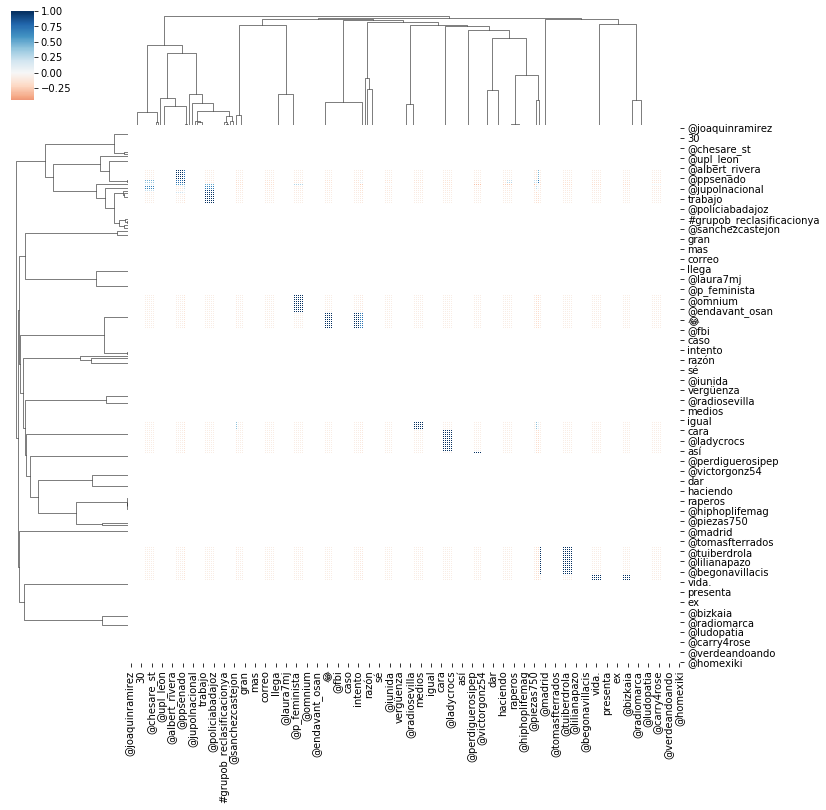

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [13]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
5      30.585817        1       1  473.643158 -506.442291
3       9.383299        1       2 -739.604309   -0.700319
8       9.161221        1       3 -210.182755 -428.943207
14      6.361077        1       4   62.840904 -704.226074
10      5.410045        1       5  -74.068512 -138.362015
6       5.303235        1       6 -607.049255 -392.982300
7       5.278833        1       7 -392.871979  -85.536705
12      5.146249        1       8  537.984680  -70.058403
4       3.338624        1       9  269.776550  389.040802
13      3.338618        1      10 -118.094704  181.971878
9       3.338606        1      11  176.400665 -338.033081
0       3.338600        1      12 -378.038757 -737.018250
1       3.338597        1      13  210.858643   37.611382
11      3.338597        1      14 -133.772339  531.532532
2       3.338597        1      15 -471.936707  295.993073, topic_info=      Category       Freq                       Term      Total  loglift  \
term                                                                       
141    Default  71.000000                   @jusapol  71.000000  30.0000   
4878   Default  23.000000                    @yozatu  23.000000  29.0000   
702    Default  35.000000            #equiparacionya  35.000000  28.0000   
4874   Default  23.000000             @hiphoplifemag  23.000000  27.0000   
4873   Default  23.000000           @franklintshimin  23.000000  26.0000   
4870   Default  23.000000                 @ayaxyprok  23.000000  25.0000   
4875   Default  23.000000                 @nachsoyyo  23.000000  24.0000   
4876   Default  22.000000                @natosywaor  22.000000  23.0000   
4877   Default  22.000000                 @piezas750  22.000000  22.0000   
4871   Default  23.000000              @elchojin_net  23.000000  21.0000   
4872   Default  23.000000            @factoria_ritmo  23.000000  20.0000   
4869   Default  22.000000            @albertobuscato  22.000000  19.0000   
543    Default  27.000000                  @ppopular  27.000000  18.0000   
70     Default  93.000000              @guardiacivil  93.000000  17.0000   
703    Default  21.000000  #grupob_reclasificacionya  21.000000  16.0000   
4982   Default  24.000000                 @senadoesp  24.000000  15.0000   
130    Default  22.000000           @sanchezcastejon  22.000000  14.0000   
3217   Default   8.000000                @erikeo5555   8.000000  13.0000   
3487   Default  27.000000                      @psoe  27.000000  12.0000   
708    Default  17.000000                    gracias  17.000000  11.0000   
4824   Default   6.000000                @jandrolion   6.000000  10.0000   
203    Default  18.000000                          d  18.000000   9.0000   
541    Default  13.000000              @pablocasado_  13.000000   8.0000   
4565   Default  15.000000                      &amp;  15.000000   7.0000   
39     Default  22.000000                         si  22.000000   6.0000   
530    Default   8.000000             @jupolnacional   8.000000   5.0000   
4556   Default  11.000000                  @upl_leon  11.000000   4.0000   
4294   Default   4.000000           @policiademadrid   4.000000   3.0000   
705    Default   7.000000             @jucilnacional   7.000000   2.0000   
9955   Default  10.000000               @europarl_es  10.000000   1.0000   
...        ...        ...                        ...        ...      ...   
1202   Topic15   0.336950                   fascista   0.464491   3.0786   
2984   Topic15   0.662507                      nada.   1.112583   2.8812   
594    Topic15   0.323092                        "la   0.472371   3.0198   
5557   Topic15   0.258032                    todavía   0.360412   3.0655   
2401   Topic15   0.345597                      pocos   0.601951   2.8447   
5280   Topic15   0.553777                       cara   1.477097   2.4185   
102    

<img src="./images/topic-modeling.png" alt="topic modeling interactive visualization" align="left"></img>


La extracción de tópicos puede responder a preguntas tales como : ¿ De qué están hablando nuestros clientes ?
